# Project Name and Description

## Contents
1. Frame the problem  and look at the big picture
2. Get the data
3. Explore and visualize the data to gain insights
4. Prepare the data to better expose the underlying patterns to machine learning algorithm
5. Explore many modesl; Select a model and train it
6. Fine-tune the model
7. Present your solution
8. Deploy, monitor and maintain your system

## 1. Frame the problem
todo


In [2]:
# Imports
import warnings
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency, kruskal, contingency


/tmp/ipykernel_227730/348397823.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# Settings
warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True)


## 2. Get the data

In [4]:
df = pd.read_csv('data/german.data', delimiter=' ', header=None)
df.tail(5)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
995,A14,12,A32,A42,1736,A61,A74,3,A92,A101,...,A121,31,A143,A152,1,A172,1,A191,A201,1
996,A11,30,A32,A41,3857,A61,A73,4,A91,A101,...,A122,40,A143,A152,1,A174,1,A192,A201,1
997,A14,12,A32,A43,804,A61,A75,4,A93,A101,...,A123,38,A143,A152,1,A173,1,A191,A201,1
998,A11,45,A32,A43,1845,A61,A73,4,A93,A101,...,A124,23,A143,A153,1,A173,1,A192,A201,2
999,A12,45,A34,A41,4576,A62,A71,3,A93,A101,...,A123,27,A143,A152,1,A173,1,A191,A201,1


In [5]:
# View the attribute names from the info document
path = 'data/german.doc'

with open(path, mode='r') as file:
    text = file.read()
    
pattern = r"Attr?ibute (?P<attr>\d{1,2}):.+?\n\s+(?P<name>.+?)\n"

print("Feature number and name:")
for m in re.finditer(pattern, text):
    print("{attr}: {name}".format(**m.groupdict()))

Feature number and name:
1: Status of existing checking account
2: Duration in month
3: Credit history
4: Purpose
5: Credit amount
6: Savings account/bonds
7: Present employment since
8: Installment rate in percentage of disposable income
9: Personal status and sex
10: Other debtors / guarantors
11: Present residence since
12: Property
13: Age in years
14: Other installment plans 
15: Housing
16: Number of existing credits at this bank
17: Job
18: Number of people being liable to provide maintenance for
19: Telephone
20: foreign worker


In [6]:
# Define short user freindly column names for easy EDA
col_names = [
    "status",    #1 (balance)
    "duration",  #2 (tenure)
    "history",   #3
    "purpose",   #4 (purpose of the loan)
    "amount",    #5 (credit amount requested)
    "savings",   #6 (savings or bonds)
    "employment",#7 (curent employment duration)
    "rate",     #8 (Installment rate in percentage of disposable income)
    "personal",  #9 (Personal status and sex)
    "guarantor", #10
    "residence", #11
    "property",  #12
    "age",       #13
    "installments", #14 (Other installment plans)
    "housing",    #15
    "credits",      #16 (Number of existing credits at this bank)
    "job",        #17
    "maintenance", #18
    "telephone",  #19
    "foreign",    #20
    "label"
            ]
df.columns = col_names

df.head()

,status,duration,history,purpose,amount,savings,employment,rate,personal,guarantor,...,property,age,installments,housing,credits,job,maintenance,telephone,foreign,label
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


### Rename the categories

In [7]:
# Make a mapping for categories
mapping = {
0: {
    'A11' : "overdrawn",
    'A12' : "little",   # up to 200 DM
    'A13' : "salary",
    'A14' : "no account"
    },

2: {
    'A30' : "no loans",
    'A31' : "duly paid",
    'A32' : "so far so good",
    'A33' : "delay",
    'A34' : "critical",
},

3: {
    'A40' : "car",
    'A41' : "used car",
    'A42' : "furniture",
    'A43' : "television",
    'A44' : "appliances",
    'A45' : "repairs",
    'A46' : "education",
    'A47' : "vacation",
    'A48' : "retraining",
    'A49' : "business",
    'A410': "other",
},

5: {
    'A61' : "[0, 1000) DM",
    'A62' : "[100, 500) DM",
    'A63' : "[500, 1000) DM",
    'A64' : "[1000, ∞) DM",
    'A65' : "no savings",
}, 

6: {
    'A71' : "unemployed",
    'A72' : "[0, 1)",
    'A73' : "[1, 4)",
    'A74' : "[4, 7)",
    'A75' : "[7, ∞)",
},

8: {
    'A91' : "male divorced/separated",
    'A92' : "female divorced/separated/married",
    'A93' : "male single",
    'A94' : "male married/widowed",
    'A95' : "female single",
},

9: {
    'A101' : "none",
    'A102' : "co-applicant",
    'A103' : "guarantor",
},

11: {
    'A121' : "real estate",
    'A122' : "building",
    'A123' : "car",
    'A124' : "unknown",
},

13: {
    'A141' : "bank",
    'A142' : "stores",
    'A143' : "none",
},

14: {
    'A151' : "rent",
    'A152' : "own",
    'A153' : "for free",
},

16: {
    'A171' : "unemployed/unskilled non-resident",
    'A172' : "unskilled",
    'A173' : "skilled",
    'A174' : "white color",
},

18: {
    'A191' : "none",
    'A192' : "yes",
},

19: {
    'A201' : True,
    'A202' : False,
},

20: {
    1: 0,  # good
    2: 1,  # bad
}}


In [8]:
# Rename the categories
for i, d in mapping.items():
    df.iloc[:, i] = df.iloc[:, i].map(d)

In [9]:
# Rearrange the columns: num, cat, label
df = pd.concat([df.select_dtypes(np.number), df.select_dtypes(object)], axis=1)
df['label'] = df.pop('label')
df.head()

,duration,amount,rate,residence,age,credits,maintenance,status,history,purpose,...,employment,personal,guarantor,property,installments,housing,job,telephone,foreign,label
0,6,1169,4,4,67,2,1,overdrawn,critical,television,...,"[7, ∞)",male single,none,real estate,none,own,skilled,yes,True,0
1,48,5951,2,2,22,1,1,up to 200 DM,so far so good,television,...,"[1, 4)",female divorced/separated/married,none,real estate,none,own,skilled,none,True,1
2,12,2096,2,3,49,1,2,no account,critical,education,...,"[4, 7)",male single,none,real estate,none,own,unskilled,none,True,0
3,42,7882,2,4,45,1,2,overdrawn,so far so good,furniture,...,"[4, 7)",male single,guarantor,building,none,for free,skilled,none,True,0
4,24,4870,3,4,53,2,2,overdrawn,delay,car,...,"[1, 4)",male single,none,unknown,none,for free,skilled,none,True,1


## Exploratory Data Analysis

In [10]:
# Number of unique values in each feature: numeric and categorical
df.nunique(0)

duration         33
amount          921
rate              4
residence         4
age              53
credits           4
maintenance       2
status            4
history           5
purpose          10
savings           5
employment        5
personal          4
guarantor         3
property          4
installments      3
housing           3
job               4
telephone         2
foreign           2
label             2
dtype: int64

In [11]:
print(f'proportion of "bad" customers: {df.label.sum() / len(df)}')

proportion of "bad" customers: 0.3


### Correlation between the independent and dependent variable / Class separation

The following histograms show us that no numerical feature separates the two classes:

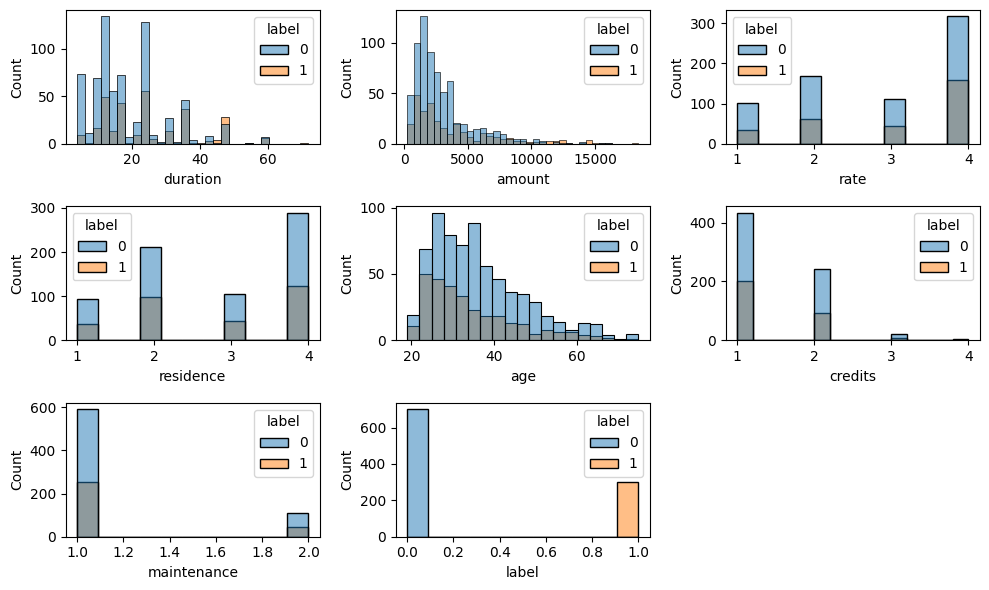

In [12]:
# Histograms of numerical features
df_num = df.select_dtypes(np.number).assign(label=df['label'])
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 6))

for i, ax in enumerate(axes.flatten()):
    if i >= df_num.shape[1]:
        plt.delaxes(ax)
        break
    sns.histplot(df_num, x=df_num.columns[i], hue='label', ax=ax)
plt.tight_layout()

Pearson's correlation coefficients below show that `duration` and `ammount` have a very weak correlation with the target:

_(we are allowed to use Person's correlation on these numerical features because the target variable is binary)_

In [27]:
df_num.corr().iloc[-1].sort_values(key=abs, ascending=False)[1:]

duration       0.214927
amount         0.154739
age           -0.091127
rate           0.072404
credits       -0.045732
maintenance   -0.003015
residence      0.002967
Name: label, dtype: float64

The following boxplots visually confirm the above Person's correlation coefficients:

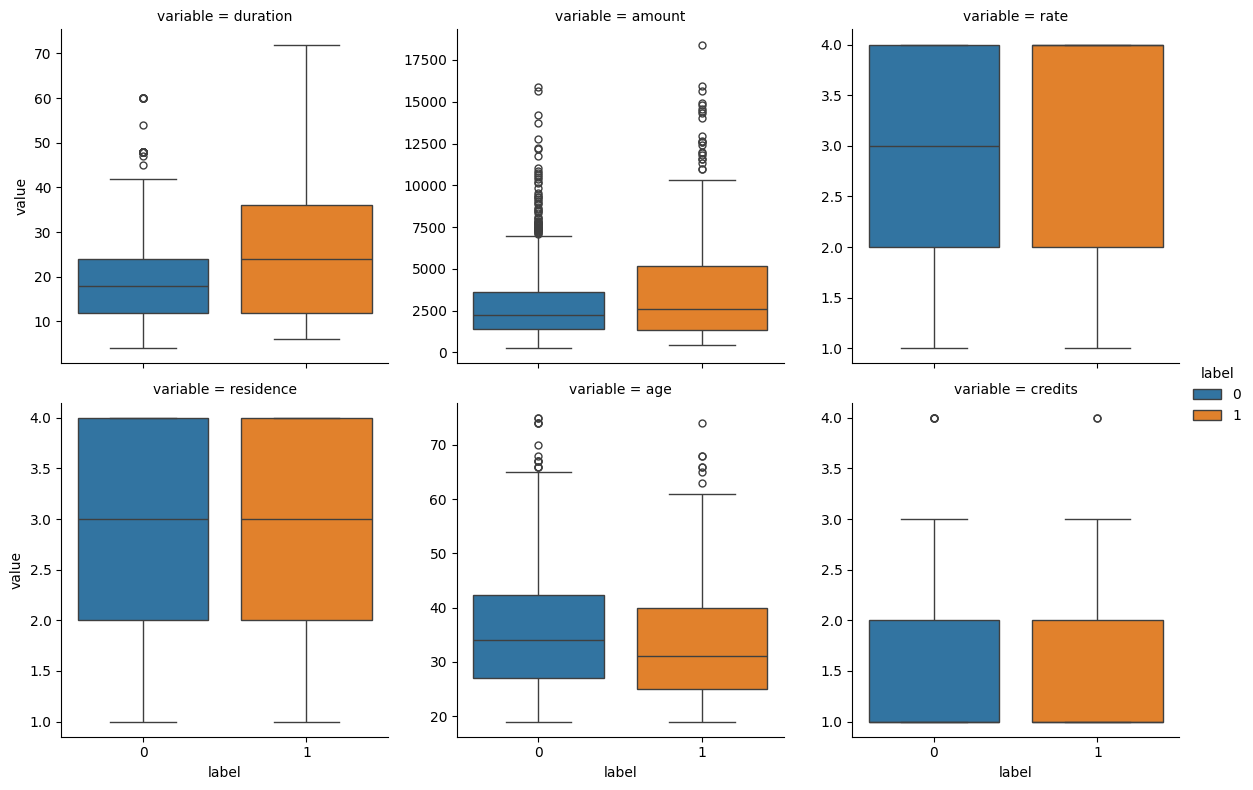

In [14]:
sns.catplot(df_num.drop('maintenance', axis=1).melt(id_vars='label'), 
            x='label', y="value", col="variable", hue='label', kind="box",
            sharey=False, col_wrap=3, height=4);

Perform Kruskal-Wallis test on these features:
- duration         
- amount          
- rate           
- residence        
- age              
- credits           

... and Chi-Squared test for independence + CramersV test on the rest of the features:

In [28]:
# Kruskal-Wallis tests

alpha = 0.01  # also try 0.05
cols = ['duration', 'amount', 'rate', 'residence', 'age', 'credits']
collector = []

for col in cols:
    res = kruskal(*df[col].groupby(df['label']).agg(list).values)
    collector.append([col, res.statistic, res.pvalue, (f"not" if res.pvalue < alpha else "") + " independent"])

pd.DataFrame(collector, columns=["feature", "H-statistic", "p-value", "verdict"]).round(2)

,feature,H-statistic,p-value,verdict
0,duration,42.26,0.00,not independent
1,amount,7.58,0.01,not independent
2,rate,5.42,0.02,independent
3,residence,0.01,0.94,independent
4,age,12.57,0.00,not independent
5,credits,2.24,0.13,independent


In [40]:
# ChiSquared and CramersV tests

alpha = 0.01
cols = ['maintenance', 'status', 'history', 'purpose', 'savings', 'employment', 'personal', 
        'guarantor', 'property', 'installments', 'housing', 'job', 'telephone', 'foreign']
collector = []

for col in cols:
    res = chi2_contingency(pd.crosstab(df[col], df['label']))
    V = contingency.association(pd.crosstab(df[col], df['label']), method='cramer')
    collector.append([
        col, res.statistic, res.pvalue, (f"not" if res.pvalue < alpha else "") + " independent",
        V, ["none", "weak", "moderate", "strong", "very strong"][np.greater(V, [.05, .1, .15, .25]).sum()]
                      ])

pd.DataFrame(collector, columns=["feature", "statistic", "p-value", f"{chr(0x03A7) + chr(0x00b2) } verdict", "V", "CramersV verdict"]).round(2)


,feature,statistic,p-value,Χ² verdict,V,CramerV verdict
0,maintenance,0.00,1.00,independent,0.00,none
1,status,123.72,0.00,not independent,0.35,very strong
2,history,61.69,0.00,not independent,0.25,strong
3,purpose,33.36,0.00,not independent,0.18,strong
4,savings,36.10,0.00,not independent,0.19,strong
5,employment,18.37,0.00,not independent,0.14,moderate
6,personal,9.61,0.02,independent,0.10,weak
7,guarantor,6.65,0.04,independent,0.08,weak
8,property,23.72,0.00,not independent,0.15,strong
9,installments,12.84,0.00,not independent,0.11,moderate


Vizualise the above findings with a 100% stacked bar:

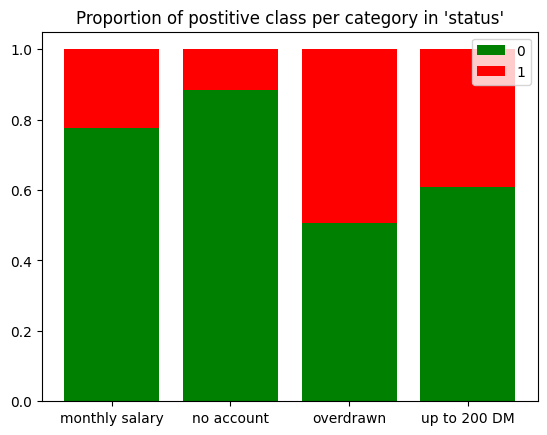

In [65]:

def plot_stacked_bar(feature):
    table = pd.crosstab(df[feature], df['label']).T
    cats = table.columns

    neg, pos = table.values

    # Convert values to proportions
    total = np.array(neg) + np.array(pos)
    neg = np.array(neg) / total
    pos = np.array(pos) / total

    # Create stacked bar chart
    plt.bar(cats, neg, label="0", color='green')
    plt.bar(cats, pos, bottom=neg, label="1", color='red')
    plt.title(f"Proportion of postitive class per category in '{feature}'")
    plt.legend()


plot_stacked_bar(feature='status')